In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')

from scipy.stats import norm
from tkinter import *
import scipy
from scipy import signal

import platform
from glob import glob
from scipy.spatial import distance
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
import IO_func as IOF
import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
import LL_funcs as LLf
import freq_funcs as ff
#
from scipy.signal import hilbert, butter, filtfilt
import scipy.stats as stats
from tqdm.notebook import trange, tqdm
import significance_funcs as sig_func

dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'InputOutput'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()
sub_path  ='X:\\4 e-Lab\\' # y:\\eLab

In [14]:
subj = 'EL025'
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'

Condition = 'Hour'  # Condition = 'Hour'
cond1 = 'h'  # h (as stored in stimlist)

######## General Infos

path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
path_gen = os.path.join(sub_path+'\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_patient, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'
    
path_labels = os.path.join(path_gen, 'Electrodes')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'

sep = ';'
Fs = 500
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/BM_plot_trial').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/single_con').mkdir(parents=True,
                                                                                              exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/Pipeline').mkdir(parents=True, exist_ok=True)

# get labels
if cond_folder == 'Ph':
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*Ph*')
else:
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist = pd.read_csv(files_list[i])
# EEG_resp = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[i][-11:-4]+'.npy')
lbls = pd.read_excel(os.path.join(path_labels, subj + "_labels.xlsx"), header=0, sheet_name='BP')
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)

labels_h = lbls.Hemisphere + '_' + labels_all

badchans = pd.read_csv(path_patient_analysis + '\\' + folder + '/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:, 1] == 1))[0, :])

bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]
file_con = path_patient_analysis + '\\'+folder+'\\'+cond_folder+'/data/con_trial_all.csv'
con_trial = pd.read_csv(file_con)

In [175]:
import h5py

In [176]:
h5_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.h5'
if os.path.isfile(h5_file):
    print('loading h5')
    EEG_resp = h5py.File(h5_file)
    EEG_resp = EEG_resp['EEG_resp']

loading h5


In [86]:
con_trial = pd.read_csv(file_con)

In [87]:
con_trial['SleepState'] ='Wake'
con_trial.loc[(con_trial.Sleep > 1) & (con_trial.Sleep < 4), 'SleepState'] = 'NREM'
con_trial.loc[(con_trial.Sleep == 1), 'SleepState'] = 'NREM1'
con_trial.loc[(con_trial.Sleep == 6), 'SleepState'] = 'SZ'
con_trial.loc[(con_trial.Sleep == 4), 'SleepState'] = 'REM'
con_trial = con_trial[con_trial.SleepState != 'NREM1']

### 1. get input matrix based on table

In [88]:
# remove bad trials
con_trial = con_trial[con_trial.Artefact == 0]
con_trial = con_trial.reset_index(drop=True)

In [89]:
## normalize LL based on the mean of LL_pre per Chan
con_trial['LL_norm'] = con_trial.groupby('Chan').apply(lambda x: x['LL'] / x['LL_BL'].mean()).reset_index(0, drop=True)
## fill nan with mean of specifc Con_ID
con_trial['LL_norm'].fillna(con_trial.groupby(['Stim', 'Chan', 'Int'])['LL_norm'].transform('mean'), inplace=True)


In [90]:
df_pivot = con_trial.pivot(index='Chan', columns='Num', values='LL_norm')
# If there are still missing values after pivot, you might want to fill them with the global mean
df_pivot.fillna(con_trial['LL_norm'].mean(), inplace=True)
V = df_pivot.values

In [51]:
print('running stability NMF')
k0 = 4
k1 = 8
# run stability NMF for different ranks
_, instability = stabNMF(V, num_it=100, k0=k0, k1=k1, init='nndsvda',it=2000)
# select rank with lowest instability value
ranks = np.arange(k0, k1+1)
k = ranks[np.argmin(instability)]

running stability NMF


In [167]:
W, H = get_nnmf(V, 8, init='random',it=2000)

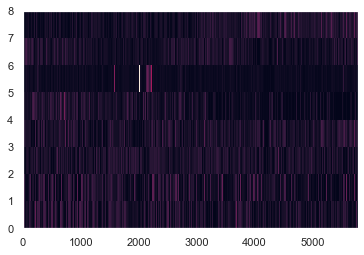

In [168]:
plt.pcolormesh(H)

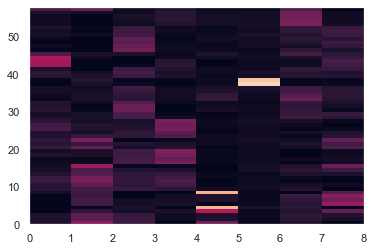

In [169]:
plt.pcolormesh(W, vmin = 0, vmax = 5)

In [163]:
import os
import numpy as np
import sys
import sklearn
from scipy import stats
from sklearn.decomposition import NMF
import pandas as pd
import random

def get_nnmf(X, rank, init='nndsvda',it=2000):
    """Non-negative matrix factorization, remove zero rows before computation."""
    W = np.zeros((X.shape[0], rank))
    zero_rows = np.where(X.mean(axis=1) == 0)[0]
    nonzero_rows = np.where(X.mean(axis=1) > 0)[0]
    X0 = np.delete(X, zero_rows, 0)

    model = NMF(n_components=rank, init=init, max_iter=it, solver='mu', beta_loss = 'kullback-leibler')
    W0 = model.fit_transform(X0)
    H = model.components_
    W[nonzero_rows, :] = W0

    return W, H

def get_nnmf_forced(m, rank, H0, W0, it=500):
    """Non-negative matrix factorization with initial guess, remove zero rows before computation."""
    W = np.zeros((m.shape[0], rank))
    zero_rows = np.where(m.mean(axis=1) == 0)[0]
    nonzero_rows = np.where(m.mean(axis=1) > 0)[0]
    X0 = np.delete(m, zero_rows, 0)
    W0 = np.delete(W0, zero_rows, 0)
    model = NMF(n_components=rank, init='custom', max_iter=it)
    W0 = model.fit_transform(X0, H=H0, W=W0)
    H = model.components_
    W[nonzero_rows, :] = W0
    return W, H

def get_W_corr(Wa, Wb):
    """Construct n by k matrix of Pearson product-moment correlation coefficients for every combination of two columns in A and B"""
    return np.corrcoef(Wa.T, Wb.T)

def max_corr(corr):
    """Get the mean of the absolute maximum correlation coefficient for each row."""
    return np.abs(corr).max(axis=0).mean()


def amariMaxError(correlation):
    """
    Computes what Wu et al. (2016) described as a 'amari-type error'
    based on average distance between factorization solutions.
    """
    maxCol = np.abs(correlation).max(axis=0)
    colTemp = (1 - maxCol).mean()
    maxRow = np.abs(correlation).max(axis=1)
    rowTemp = (1 - maxRow).mean()
    return (rowTemp + colTemp) / 2



def stabNMF(M_input, num_it=100, k0=2, k1=10, init='nndsvda',it=2000):
    d = M_input.shape[0]  # number of features
    stability = np.zeros((k1 - k0 + 1,))
    instability = np.zeros((k1 - k0 + 1,))

    for k_num, k in enumerate(range(k0, k1 + 1)):  # for each rank
        print(str(k_num)+'/'+str(k1 - k0 + 1), end="\r")
        # for each rank value
        W_all = np.zeros((num_it, d, k))
        for n in range(num_it):
            W, H = get_nnmf(M_input, k)
            W_all[n, :, :] = W

        for i in range(num_it):
            for j in range(i, num_it):
                x = W_all[i]
                y = W_all[j]
                CORR = get_W_corr(x, y)
                simMat_ij = max_corr(CORR) if i != j else 0  # amariMaxError(CORR) if i == j else max_corr(CORR)
                distMat_ij = amariMaxError(CORR)
                stability[k_num] += simMat_ij / (num_it * (num_it - 1) / 2)
                instability[k_num] += distMat_ij / (num_it * (num_it - 1))

    return stability, instability


In [ ]:
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'white'})

In [ ]:
con_trial.groupby()

In [98]:
con_trial[(con_trial.Stim==sc)&(con_trial.LL_norm>3)]

,Chan,Stim,LL,LL_BL,Artefact,Int,Condition,Hour,Block,Sleep,Num,Num_block,Date,d,SleepState,LL_norm
447,3.0,1.0,4.954199,1.981109,0.0,8.0,0.0,18.0,2.0,0.0,32.0,32.0,20230606.0,7.00,Wake,3.025693
450,3.0,1.0,5.004806,3.546911,0.0,8.0,0.0,18.0,2.0,0.0,35.0,35.0,20230606.0,7.00,Wake,3.056601
539,3.0,1.0,5.099487,1.115881,0.0,10.0,0.0,19.0,2.0,0.0,126.0,126.0,20230606.0,7.00,Wake,3.114426
544,3.0,1.0,5.779435,1.420463,0.0,12.0,0.0,19.0,2.0,0.0,131.0,131.0,20230606.0,7.00,Wake,3.529693
565,3.0,1.0,5.322928,2.283262,0.0,6.0,0.0,19.0,2.0,0.0,152.0,152.0,20230606.0,7.00,Wake,3.250889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283802,7.0,1.0,9.760886,3.500132,0.0,12.0,0.0,8.0,30.0,0.0,5736.0,305.0,20230608.0,21.00,Wake,5.667942
283814,7.0,1.0,6.706005,2.215870,0.0,8.0,0.0,8.0,30.0,0.0,5753.0,322.0,20230608.0,21.00,Wake,3.894036
283830,7.0,1.0,6.745037,2.039430,0.0,5.0,0.0,8.0,30.0,0.0,5778.0,347.0,20230608.0,21.00,Wake,3.916701
283831,7.0,1.0,6.480886,3.690137,0.0,10.0,0.0,8.0,30.0,0.0,5782.0,351.0,20230608.0,21.00,Wake,3.763314


In [104]:
con_trial_mean = con_trial.groupby(['Stim', 'Chan', 'Int'], as_index =False)['LL_norm'].mean()
con_trial_mean

,Stim,Chan,Int,LL_norm
0,1.0,3.0,0.2,0.979408
1,1.0,3.0,0.4,1.018712
2,1.0,3.0,0.6,1.079862
3,1.0,3.0,0.8,1.079247
4,1.0,3.0,1.0,1.199663
...,...,...,...,...
4646,34.0,57.0,7.0,2.395459
4647,34.0,57.0,8.0,2.353541
4648,34.0,57.0,9.0,2.350609
4649,34.0,57.0,10.0,2.247046


In [207]:
np.unique(con_trial_mean.Stim)

array([ 1.,  6., 28., 33., 34.])

In [208]:
sc = 1
np.unique(con_trial_mean.loc[(con_trial_mean.Stim==sc)&(con_trial_mean.LL_norm>2),'Chan'])

array([3., 4., 8.])

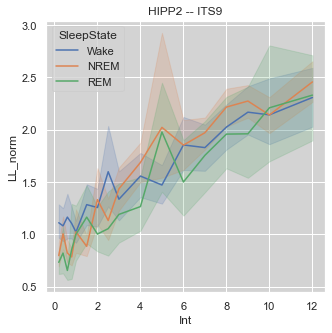

In [209]:
rc = 8
data_plot = con_trial.loc[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Sleep!=1)]
fig = plt.figure(figsize=(5,5))
fig.patch.set_facecolor('xkcd:white')
plt.title(labels_all[sc]+' -- '+labels_all[rc])
sns.lineplot(x='Int', y= 'LL_norm', hue='SleepState', data = data_plot)
plt.show()
# plt.ylim([0,10])

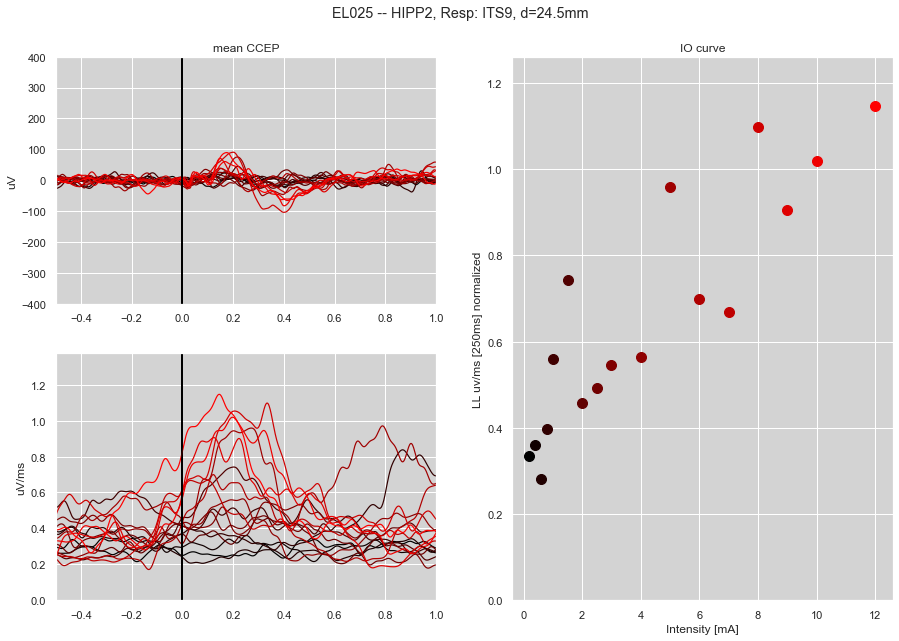

In [210]:
plot_raw_LL_IO(sc, rc, con_trial[con_trial.SleepState=='REM'],EEG_resp,labels_all)

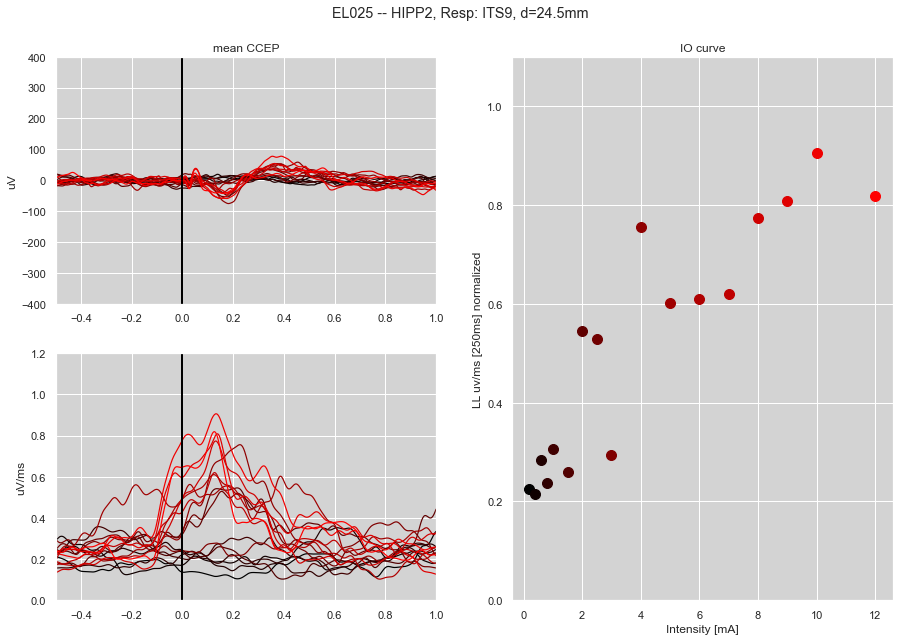

In [211]:
plot_raw_LL_IO(sc, rc, con_trial[con_trial.SleepState=='NREM'],EEG_resp,labels_all)

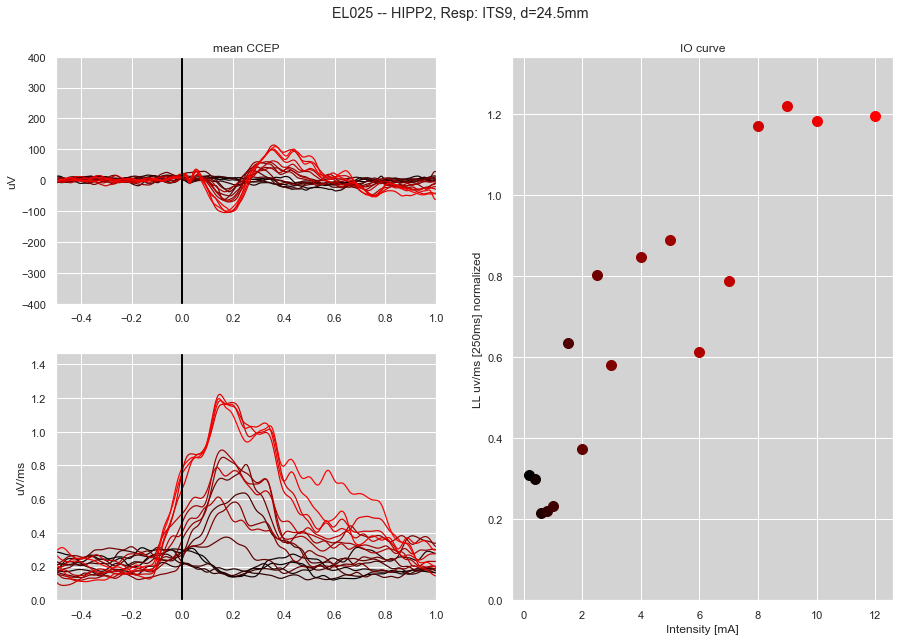

In [212]:
plot_raw_LL_IO(sc, rc, con_trial[con_trial.SleepState=='Wake'],EEG_resp,labels_all)

In [170]:
def plot_raw_LL_IO(sc, rc, LL_all,EEG_resp,labels_all):
    dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]
    w        = 0.25
    fig, axs = plt.subplots(2,2, figsize=(15, 8), facecolor='w', edgecolor='k')
    axs     = axs.ravel()
    plt.close(fig) # todo: find better solution
    fig      = plt.figure(figsize=(15,10), facecolor='w', edgecolor='k')
    #
    gs       = fig.add_gridspec(2,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for n in range(2):
        axs[n] = fig.add_subplot(gs[n, 0])

    axIO   = fig.add_subplot(gs[:, 1])
    plt.suptitle(subj+' -- '+labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(dat.d),1))+'mm', y=0.95)
    limy_LL          = 3 # limits for LL plot
    limy_mx        = 200
    limy_mn        = -200
    Int_selc         = np.unique(dat.Int)
    colors_Int       = np.zeros((len(Int_selc), 3))
    colors_Int[:, 0] = np.linspace(0, 1, len(Int_selc))
    mx_LL =1
    
    Int_selc = np.unique(dat.loc[(dat.Stim==sc)&(dat.Chan==rc)&(dat.Artefact<1), 'Int'])
    for i in range(len(Int_selc)):
        dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Artefact<1)]
        if len(dati)>0:
            resp             = ff.lp_filter(np.nanmean(EEG_resp[rc,dati.Num.values.astype('int'),: ], 0),45,Fs)
            LL_resp = LLf.get_LL_all(np.expand_dims(resp,[0,1]), Fs, 0.25)[0][0]

            LL_resp             = ff.lp_filter(LL_resp,20,Fs)
            axs[0].plot( x_ax,resp, c = colors_Int[i], linewidth= 1.2)
            axs[0].set_xlim(-0.5, 1)
            axs[0].axvline(0, c=[0,0,0])   
            axs[0].set_ylabel('uV')
            
            axs[1].plot( x_ax,LL_resp, c = colors_Int[i], linewidth= 1.2)
            axs[1].set_xlim(-0.5, 1)
            axs[1].axvline(0, c=[0,0,0])   
            axs[1].set_ylabel('uV/ms')
            
            # axs[1].plot( x_ax,LL_resp, c = colors_Int[i], linewidth= 1.2)
            mx = np.max(LL_resp[500:750])
            mx_t = np.argmax(LL_resp[500:750]) /Fs
            # axs[1].plot(mx_t,mx, marker='o', c = [0,0,0], markersize= 10)


            axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = colors_Int[i])

            limy_mx = np.nanmax([limy_mx, np.max(resp[500:750])])
            limy_mn = np.nanmin([limy_mn, np.min(resp[500:750])])
            mx_LL = np.max([mx_LL, mx])
            
            


    axIO.set_title('IO curve')
    axIO.set_ylabel('LL uv/ms [250ms] normalized')
    axIO.set_xlabel('Intensity [mA]')
    axIO.set_ylim([0,1.1*mx_LL])
    axs[0].set_title('mean CCEP')
    axs[1].set_ylim([0,1.2*mx_LL])
    axs[0].set_ylim([-400,400])


In [17]:
data_plot

,Chan,Stim,LL,LL_BL,Artefact,Int,Condition,Hour,Block,Sleep,Num,Num_block,Date,d
5304,26.0,28.0,3.174456,3.498831,0.0,3.0,0.0,18.0,2.0,0.0,0.0,0.0,20230606.0,23.76
5305,26.0,28.0,5.368647,3.164941,0.0,2.5,0.0,18.0,2.0,0.0,1.0,1.0,20230606.0,23.76
5306,26.0,28.0,2.394830,5.149343,0.0,2.0,0.0,18.0,2.0,0.0,2.0,2.0,20230606.0,23.76
5307,26.0,28.0,4.157298,3.006170,0.0,4.0,0.0,18.0,2.0,0.0,3.0,3.0,20230606.0,23.76
5309,26.0,28.0,3.479553,1.676140,0.0,0.2,0.0,18.0,2.0,0.0,5.0,5.0,20230606.0,23.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324854,26.0,28.0,3.055087,3.319052,0.0,1.0,0.0,8.0,30.0,0.0,5773.0,342.0,20230608.0,23.76
324857,26.0,28.0,3.012114,3.753182,0.0,5.0,0.0,8.0,30.0,0.0,5776.0,345.0,20230608.0,23.76
324867,26.0,28.0,2.552777,3.786869,0.0,9.0,0.0,8.0,30.0,0.0,5786.0,355.0,20230608.0,23.76
324873,26.0,28.0,2.654751,4.075751,0.0,7.0,0.0,8.0,30.0,0.0,5792.0,361.0,20230608.0,23.76


In [15]:
con_trial_IO

,Chan,Stim,LL,LL_BL,Artefact,Int,Condition,Hour,Block,Sleep,Num,Num_block,Date,d
0,0.0,28.0,1.737101,1.734295,0.0,3.0,0.0,18.0,2.0,0.0,0.0,0.0,20230606.0,61.48
1,0.0,28.0,2.953374,1.418579,0.0,2.5,0.0,18.0,2.0,0.0,1.0,1.0,20230606.0,61.48
2,0.0,28.0,1.955859,2.700258,0.0,2.0,0.0,18.0,2.0,0.0,2.0,2.0,20230606.0,61.48
3,0.0,28.0,4.885619,2.242376,0.0,4.0,0.0,18.0,2.0,0.0,3.0,3.0,20230606.0,61.48
4,0.0,34.0,4.998166,1.987057,0.0,10.0,0.0,18.0,2.0,0.0,4.0,4.0,20230606.0,49.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336250,57.0,28.0,4.251379,2.334330,0.0,7.0,0.0,8.0,30.0,0.0,5792.0,361.0,20230608.0,41.26
336251,57.0,33.0,2.634024,1.757511,0.0,1.0,0.0,8.0,30.0,0.0,5793.0,362.0,20230608.0,36.53
336252,57.0,1.0,1.547075,1.532679,0.0,4.0,0.0,8.0,30.0,0.0,5794.0,363.0,20230608.0,80.50
336253,57.0,33.0,1.887488,1.753690,0.0,1.5,0.0,8.0,30.0,0.0,5795.0,364.0,20230608.0,36.53
